In [1]:
import pandas as pd
import numpy as np
import os

df_limited_p1 = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\p1_limited.csv')
df_p2 = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\p2.csv')
df_p3 = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\p3.csv')

df_limited_p1 = df_limited_p1.dropna()
df_p2 = df_p2.dropna()
df_p3 = df_p3.dropna()

In [2]:
os.chdir("..") 
from src import feature_extraction, models, utils
from src.models import multioutput_models

p1_x = df_limited_p1.drop(columns=['volume', 'substance'])
p1_y = df_limited_p1[['substance', 'volume']]

p1_x_train, p1_x_test, p1_y_train, p1_y_test = models.make_split(p1_x, p1_y, 42)

p2_x = df_p2.drop(columns=['volume', 'substance'])
p2_y = df_p2[['substance', 'volume']]

p2_x_train, p2_x_test, p2_y_train, p2_y_test = models.make_split(p2_x, p2_y, 42)

p3_x = df_p3.drop(columns=['volume', 'substance'])
p3_y = df_p3[['substance', 'volume']]

p3_x_train, p3_x_test, p3_y_train, p3_y_test = models.make_split(p3_x, p3_y, 42)

In [3]:
from sklearn.base import clone

def train_and_save_models(x_train, x_test, y_train, y_test):
    acc = []
    per_label_acc = []

    models_copy = [[name, clone(model)] for name, model in multioutput_models]

    for model in models_copy:
        model[1].fit(x_train, y_train)
        y_pred = model[1].predict(x_test)

        # Exact match accuracy (all labels correct)
        exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

        # Per-label accuracy
        per_label_accuracy = (y_test == y_pred).mean(axis=0)

        acc.append(exact_match_accuracy * 100)
        per_label_acc.append(per_label_accuracy * 100)

    models.print_metrics(acc, per_label_acc)

    return acc, per_label_acc, models_copy

def holdout_validation(x_test, y_test, models):
    acc = []
    per_label_acc = []

    for model in models:
        y_pred = model[1].predict(x_test)

        # Exact match accuracy (all labels correct)
        exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

        # Per-label accuracy
        per_label_accuracy = (y_test == y_pred).mean(axis=0)

        acc.append(exact_match_accuracy * 100)
        per_label_acc.append(per_label_accuracy * 100)

    return acc, per_label_acc

In [4]:
p1_acc, p1_label_acc, p1_models = train_and_save_models(p1_x_train, p1_x_test, p1_y_train, p1_y_test)

SVM
Exact Match Accuracy: 75.0000
Per-Label Accuracies: [100.  75.]
----------------------------
KNN
Exact Match Accuracy: 87.5000
Per-Label Accuracies: [100.   87.5]
----------------------------
Decision Tree
Exact Match Accuracy: 50.0000
Per-Label Accuracies: [62.5 87.5]
----------------------------
Naive Bayes
Exact Match Accuracy: 62.5000
Per-Label Accuracies: [87.5 75. ]
----------------------------
Logistic Regression
Exact Match Accuracy: 87.5000
Per-Label Accuracies: [100.   87.5]
----------------------------
Gradient Boost
Exact Match Accuracy: 75.0000
Per-Label Accuracies: [87.5 75. ]
----------------------------


In [5]:
p2_acc, p2_label_acc = holdout_validation(p2_x_test, p2_y_test, p1_models)

In [6]:
p3_acc, p3_label_acc = holdout_validation(p3_x_test, p3_y_test, p1_models)

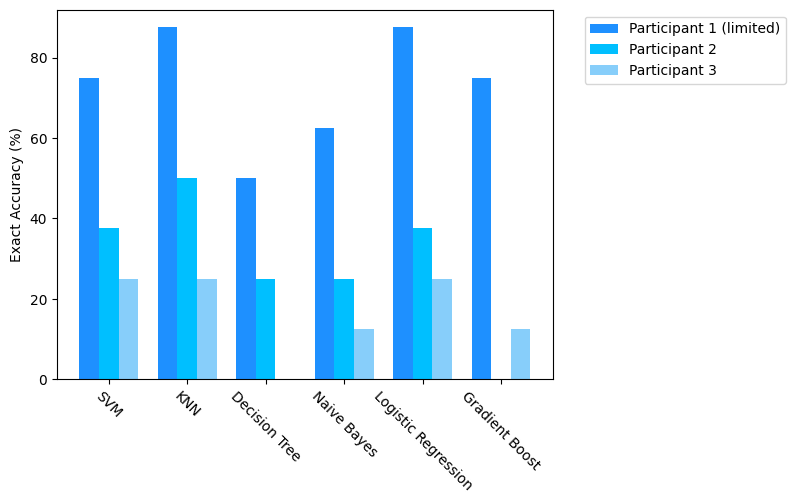

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(multioutput_models))  # [0, 1, 2]
width = 0.25  # width of each bar

# Plot bars side by side
plt.bar(x - width, p1_acc, width, label='Participant 1 (limited)', color='dodgerblue')
plt.bar(x, p2_acc, width, label='Participant 2', color='deepskyblue')
plt.bar(x + width, p3_acc, width, label='Participant 3', color='lightskyblue')

# Add labels
model_names = [name for name, _ in multioutput_models]

plt.xticks(x, model_names, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()